Dice Score: 0.42859214151080177


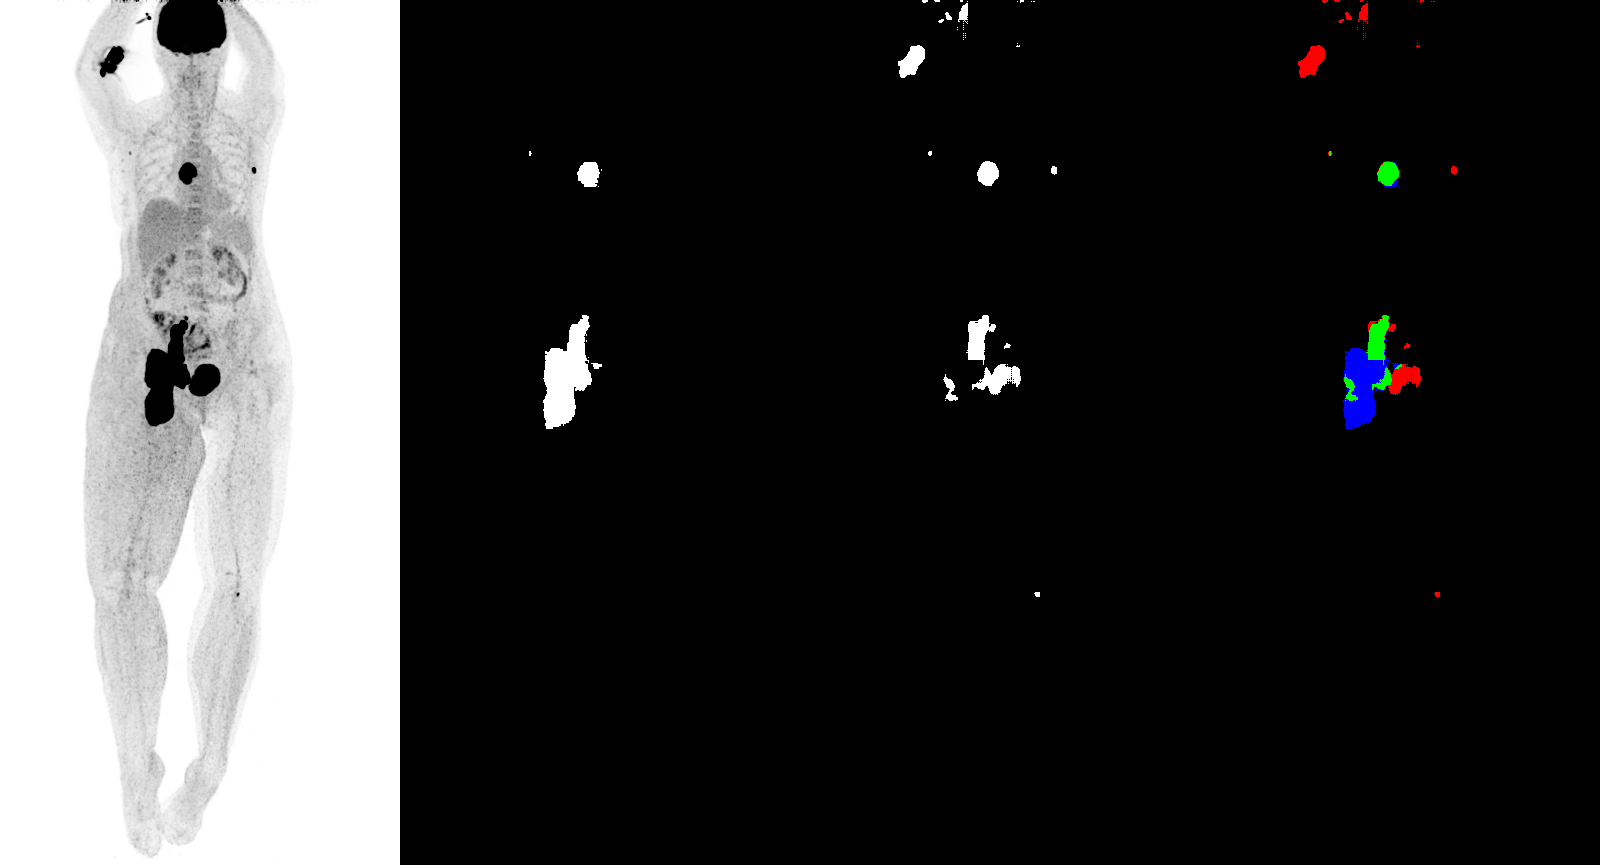

In [5]:
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
import numpy as np
from io import BytesIO
import sys
sys.path.append('/home/magsam/workspace/tumor-segmentation')
from src.model import attention_unet

model = attention_unet.AttentionUnetModel(model_path="/home/magsam/workspace/tumor-segmentation/src/model/best_metric_model_segmentation2d_dict.pth")

# Load your images
def read_images(patient, ground_truth):
    pet_mip_image = Image.open(patient)
    predicted_segmentation_image = model.infer(patient)
    true_segmentation_image = Image.open(ground_truth)

    # Convert images to grayscale for comparison
    predicted_segmentation_image = predicted_segmentation_image.convert('L')
    true_segmentation_image = true_segmentation_image.convert('L')
    
    return pet_mip_image, predicted_segmentation_image, true_segmentation_image

pet_mip_image, predicted_segmentation_image, true_segmentation_image = read_images('/home/magsam/workspace/tumor-segmentation/data/patients/imgs/patient_152.png', '/home/magsam/workspace/tumor-segmentation/data/patients/labels/segmentation_152.png')

# Create a new image with the combined size
total_width = max(pet_mip_image.width + true_segmentation_image.width + predicted_segmentation_image.width + predicted_segmentation_image.width, 919)
total_height = max(pet_mip_image.height, true_segmentation_image.height, predicted_segmentation_image.height)
combined_image = Image.new('RGB', (total_width, total_height), color='white')

#Create TP, FP, FN images
# Create a new image for the overlay with the same size as the segmentation images
overlay_image = Image.new('RGB', predicted_segmentation_image.size)

# Define colors for TP, FP, FN
colors = {'TP': (0, 255, 0), 'FP': (255, 0, 0), 'FN': (0, 0, 255)}

# Get the data of the images
true_data = true_segmentation_image.getdata()
predicted_data = predicted_segmentation_image.getdata()

# Process the images and assign colors
new_data = []
for true_pixel, pred_pixel in zip(true_data, predicted_data):
    if true_pixel == 255 and pred_pixel == 255:
        new_data.append(colors['TP'])  # True Positive
    elif true_pixel == 0 and pred_pixel == 255:
        new_data.append(colors['FP'])  # False Positive
    elif true_pixel == 255 and pred_pixel == 0:
        new_data.append(colors['FN'])  # False Negative
    else:
        new_data.append((0, 0, 0))  # True Negative (or background)

# Update the overlay image with the new data
overlay_image.putdata(new_data)

# Paste the images into the combined image
combined_image.paste(pet_mip_image, (0, 0))
combined_image.paste(true_segmentation_image, (pet_mip_image.width, 0))
combined_image.paste(predicted_segmentation_image, (pet_mip_image.width + true_segmentation_image.width, 0))
combined_image.paste(overlay_image, (pet_mip_image.width + true_segmentation_image.width + predicted_segmentation_image.width, 0))


def calculate_dice(true_segmentation, predicted_segmentation):
    # Flatten the image arrays and convert to boolean values where white (255) is True and black (0) is False
    true_array = np.array(true_segmentation).flatten() > 0
    predicted_array = np.array(predicted_segmentation).flatten() > 0
    
    # Calculate intersection and union
    intersection = np.logical_and(true_array, predicted_array).sum()
    true_sum = true_array.sum()
    predicted_sum = predicted_array.sum()
    
    # Calculate Dice score
    dice_score = 2. * intersection / (true_sum + predicted_sum)
    
    return dice_score

# Call the function with your image data
dice_score = calculate_dice(true_segmentation_image, predicted_segmentation_image)
print(f'Dice Score: {dice_score}')



display(combined_image)